# Extract MLP's matrix of weights

In [1]:
# Download all needed dependencies
! pip install git+https://github.com/aimclub/eXplain-NNs &> /dev/null
! pip install torchmetrics &> /dev/null
! pip install giotto-ph==0.2.2 &> /dev/null
! pip install giotto-tda==0.6.0 &> /dev/null
! pip install umap-learn==0.5.3 &> /dev/null

In [2]:
# Importing all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import eXNN.topology

import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Read preprocessed bike dataset
prep_bike_df = pd.read_csv('./prep_bike_data.csv')
prep_bike_df

,rank(season),yr,rank(mnth),rank(hr),holiday,rank(weekday),workingday,weathersit,rank(temp),rank(atemp),rank(hum),rank(windspeed),rank(casual),rank(registered),cnt
0,-1.16483,0,-1.737916,-2.035759,0,1.459083,0,1,-1.276942,-0.946560,0.770810,-1.532339,-0.774893,-1.037755,16
1,-1.16483,0,-1.737916,-1.533273,0,1.459083,0,1,-1.448913,-1.045073,0.734244,-1.532339,-0.356451,-0.699187,40
2,-1.16483,0,-1.737916,-1.259057,0,1.459083,0,1,-1.448913,-1.045073,0.734244,-1.532339,-0.564583,-0.766063,32
3,-1.16483,0,-1.737916,-1.059753,0,1.459083,0,1,-1.276942,-0.946560,0.509186,-1.532339,-0.774893,-1.126601,13
4,-1.16483,0,-1.737916,-0.897469,0,1.459083,0,1,-1.276942,-0.946560,0.509186,-1.532339,-1.690293,-2.448942,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,-1.16483,1,1.720548,0.883425,0,-0.788204,1,2,-1.117398,-1.152974,-0.121890,-0.127559,-0.204644,-0.057581,119
17375,-1.16483,1,1.720548,1.051068,0,-0.788204,1,2,-1.117398,-1.152974,-0.121890,-0.127559,-0.356451,-0.265968,89
17376,-1.16483,1,1.720548,1.255084,0,-0.788204,1,1,-1.117398,-1.152974,-0.121890,-0.127559,-0.417236,-0.250236,90
17377,-1.16483,1,1.720548,1.531407,0,-0.788204,1,1,-1.117398,-1.045073,-0.276442,-0.384024,-0.119057,-0.537970,61


In [31]:
# Create a Full-Connected Neural Network class
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(MultiLayerPerceptron, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Dropout(0.23)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(120, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.Dropout(0.23)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(150, 140),
            nn.BatchNorm1d(140),
            nn.ReLU(),
            nn.Dropout(0.23)
        )

        self.layer4 = nn.Sequential(
            nn.Linear(140, 250),
            nn.BatchNorm1d(250),
            nn.ReLU(),   
            nn.Dropout(0.23)
        )

        self.layer5 = nn.Sequential(
            nn.Linear(250, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Dropout(0.23)
        )
    
        self.layer6 = nn.Sequential(
            nn.Linear(120, output_dim),
            # nn.Sigmoid()
        )

    # Define forward loop for NN
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

In [16]:
# Define function for calculation RMSE
def root_mean_squared_error(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [35]:
# Define training and evaluating steps
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs):
    train_losses = list()
    test_losses = list()
    rmse_scores = list()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            all_outputs = list()
            all_targets = list()
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                all_outputs.append(outputs)
                all_targets.append(targets)

            test_loss /= len(test_loader)
            test_losses.append(test_loss)

            all_outputs = torch.cat(all_outputs, dim=0)
            all_targets = torch.cat(all_targets, dim=0)
            rmse_value = root_mean_squared_error(all_targets, all_outputs)
            rmse_scores.append(rmse_value)
        scheduler.step()


        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, RMSE: {rmse_value:.4f}')

    # Loss and MAPE visualisation
    fig = plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.plot(rmse_scores, label='RMSE')
    plt.title('Loss and RMSE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True)
    plt.show()

    return fig

In [48]:
# Define function for training network on non-full data
def batch_fit(batch_df, epochs: int):
    # Separate data into features and targets
    X = batch_df.iloc[:, :-1].values
    y = batch_df.iloc[:, -1].values
    y = y.reshape(-1, 1)

    # Data normalization
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)

    # Splitting data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=42)

    # Convertation data to PyTorch tensors
    train_features = torch.tensor(X_train, dtype=torch.float32)
    test_features = torch.tensor(X_test, dtype=torch.float32)
    train_targets = torch.tensor(y_train, dtype=torch.float32)
    test_targets = torch.tensor(y_test, dtype=torch.float32)    

    # Creating DataLoader
    train_data = TensorDataset(train_features, train_targets)
    test_data = TensorDataset(test_features, test_targets)

    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

    # Model initialization
    model = MultiLayerPerceptron(14, 1)

    # Define optimizator and loss function
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=6.4905716870829137e-05, weight_decay=0.1)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

    # Perform training
    fig = train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs)

    return model.state_dict(), fig, model, test_data

Epoch 1/40, Train Loss: 0.1738, Test Loss: 0.0401, RMSE: 0.1999
Epoch 2/40, Train Loss: 0.1389, Test Loss: 0.0316, RMSE: 0.1764
Epoch 3/40, Train Loss: 0.1242, Test Loss: 0.0262, RMSE: 0.1607
Epoch 4/40, Train Loss: 0.1114, Test Loss: 0.0267, RMSE: 0.1622
Epoch 5/40, Train Loss: 0.1043, Test Loss: 0.0257, RMSE: 0.1591
Epoch 6/40, Train Loss: 0.0971, Test Loss: 0.0223, RMSE: 0.1486
Epoch 7/40, Train Loss: 0.0920, Test Loss: 0.0181, RMSE: 0.1336
Epoch 8/40, Train Loss: 0.0861, Test Loss: 0.0185, RMSE: 0.1352
Epoch 9/40, Train Loss: 0.0844, Test Loss: 0.0170, RMSE: 0.1297
Epoch 10/40, Train Loss: 0.0851, Test Loss: 0.0164, RMSE: 0.1274
Epoch 11/40, Train Loss: 0.0767, Test Loss: 0.0171, RMSE: 0.1299
Epoch 12/40, Train Loss: 0.0778, Test Loss: 0.0154, RMSE: 0.1230
Epoch 13/40, Train Loss: 0.0722, Test Loss: 0.0150, RMSE: 0.1221
Epoch 14/40, Train Loss: 0.0724, Test Loss: 0.0156, RMSE: 0.1240
Epoch 15/40, Train Loss: 0.0674, Test Loss: 0.0145, RMSE: 0.1199
Epoch 16/40, Train Loss: 0.0650, T

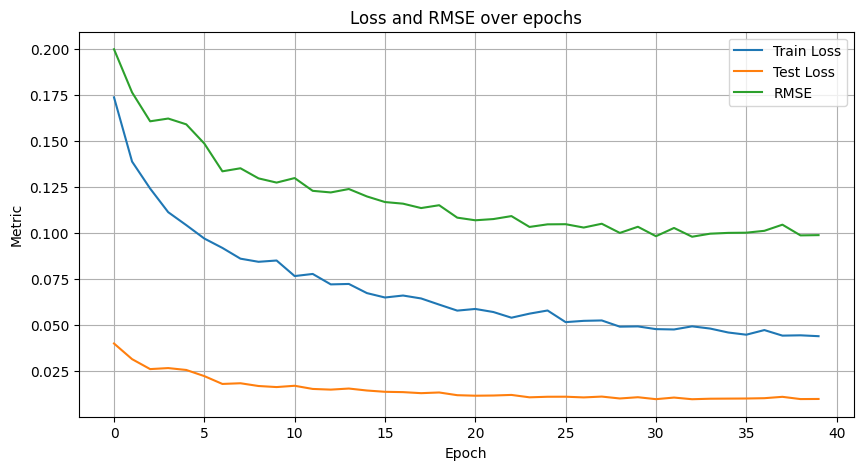

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.3327, Test Loss: 0.1240, RMSE: 0.3507
Epoch 2/40, Train Loss: 0.1658, Test Loss: 0.0571, RMSE: 0.2371
Epoch 3/40, Train Loss: 0.1173, Test Loss: 0.0226, RMSE: 0.1495
Epoch 4/40, Train Loss: 0.0952, Test Loss: 0.0163, RMSE: 0.1266
Epoch 5/40, Train Loss: 0.0869, Test Loss: 0.0134, RMSE: 0.1145
Epoch 6/40, Train Loss: 0.0824, Test Loss: 0.0121, RMSE: 0.1089
Epoch 7/40, Train Loss: 0.0718, Test Loss: 0.0126, RMSE: 0.1112
Epoch 8/40, Train Loss: 0.0704, Test Loss: 0.0101, RMSE: 0.0990
Epoch 9/40, Train Loss: 0.0660, Test Loss: 0.0098, RMSE: 0.0981
Epoch 10/40, Train Loss: 0.0645, Test Loss: 0.0099, RMSE: 0.0987
Epoch 11/40, Train Loss: 0.0590, Test Loss: 0.0068, RMSE: 0.0820
Epoch 12/40, Train Loss: 0.0567, Test Loss: 0.0063, RMSE: 0.0785
Epoch 13/40, Train Loss: 0.0534, Test Loss: 0.0061, RMSE: 0.0774
Epoch 14/40, Train Loss: 0.0508, Test Loss: 0.0060, RMSE: 0.0774
Epoch 15/40, Train Loss: 0.0453, Test Loss: 0.0050, RMSE: 0.0701
Epoch 16/40, Train Loss: 0.0469, T

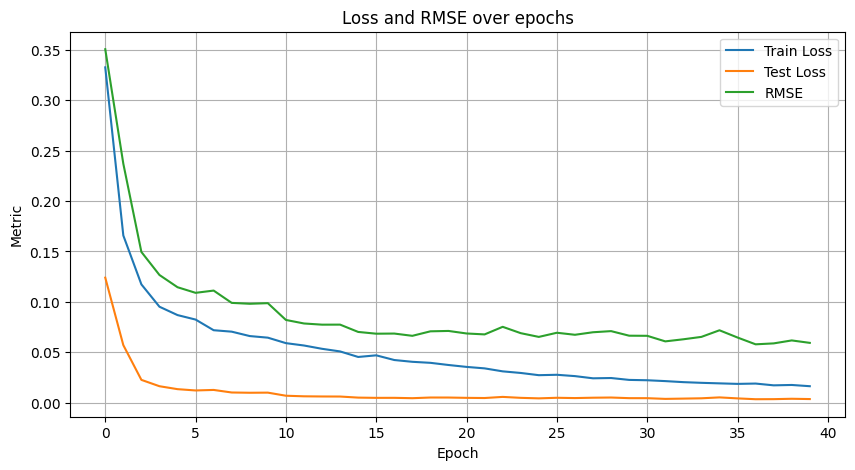

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.2176, Test Loss: 0.0573, RMSE: 0.2383
Epoch 2/40, Train Loss: 0.1093, Test Loss: 0.0266, RMSE: 0.1634
Epoch 3/40, Train Loss: 0.0882, Test Loss: 0.0195, RMSE: 0.1386
Epoch 4/40, Train Loss: 0.0775, Test Loss: 0.0165, RMSE: 0.1280
Epoch 5/40, Train Loss: 0.0695, Test Loss: 0.0130, RMSE: 0.1138
Epoch 6/40, Train Loss: 0.0620, Test Loss: 0.0125, RMSE: 0.1087
Epoch 7/40, Train Loss: 0.0548, Test Loss: 0.0092, RMSE: 0.0946
Epoch 8/40, Train Loss: 0.0506, Test Loss: 0.0098, RMSE: 0.0974
Epoch 9/40, Train Loss: 0.0456, Test Loss: 0.0091, RMSE: 0.0947
Epoch 10/40, Train Loss: 0.0396, Test Loss: 0.0069, RMSE: 0.0831
Epoch 11/40, Train Loss: 0.0361, Test Loss: 0.0074, RMSE: 0.0852
Epoch 12/40, Train Loss: 0.0349, Test Loss: 0.0070, RMSE: 0.0828
Epoch 13/40, Train Loss: 0.0296, Test Loss: 0.0064, RMSE: 0.0798
Epoch 14/40, Train Loss: 0.0269, Test Loss: 0.0066, RMSE: 0.0817
Epoch 15/40, Train Loss: 0.0258, Test Loss: 0.0063, RMSE: 0.0793
Epoch 16/40, Train Loss: 0.0232, T

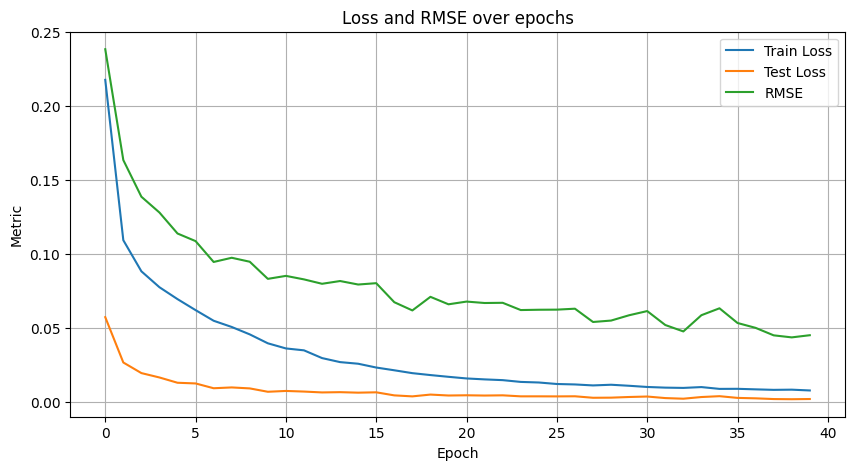

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.1486, Test Loss: 0.0270, RMSE: 0.1638
Epoch 2/40, Train Loss: 0.0977, Test Loss: 0.0212, RMSE: 0.1450
Epoch 3/40, Train Loss: 0.0752, Test Loss: 0.0165, RMSE: 0.1281
Epoch 4/40, Train Loss: 0.0656, Test Loss: 0.0131, RMSE: 0.1139
Epoch 5/40, Train Loss: 0.0551, Test Loss: 0.0109, RMSE: 0.1036
Epoch 6/40, Train Loss: 0.0469, Test Loss: 0.0117, RMSE: 0.1079
Epoch 7/40, Train Loss: 0.0398, Test Loss: 0.0104, RMSE: 0.1016
Epoch 8/40, Train Loss: 0.0341, Test Loss: 0.0085, RMSE: 0.0920
Epoch 9/40, Train Loss: 0.0297, Test Loss: 0.0083, RMSE: 0.0905
Epoch 10/40, Train Loss: 0.0253, Test Loss: 0.0078, RMSE: 0.0878
Epoch 11/40, Train Loss: 0.0211, Test Loss: 0.0065, RMSE: 0.0799
Epoch 12/40, Train Loss: 0.0175, Test Loss: 0.0059, RMSE: 0.0765
Epoch 13/40, Train Loss: 0.0161, Test Loss: 0.0062, RMSE: 0.0780
Epoch 14/40, Train Loss: 0.0142, Test Loss: 0.0052, RMSE: 0.0714
Epoch 15/40, Train Loss: 0.0124, Test Loss: 0.0044, RMSE: 0.0659
Epoch 16/40, Train Loss: 0.0115, T

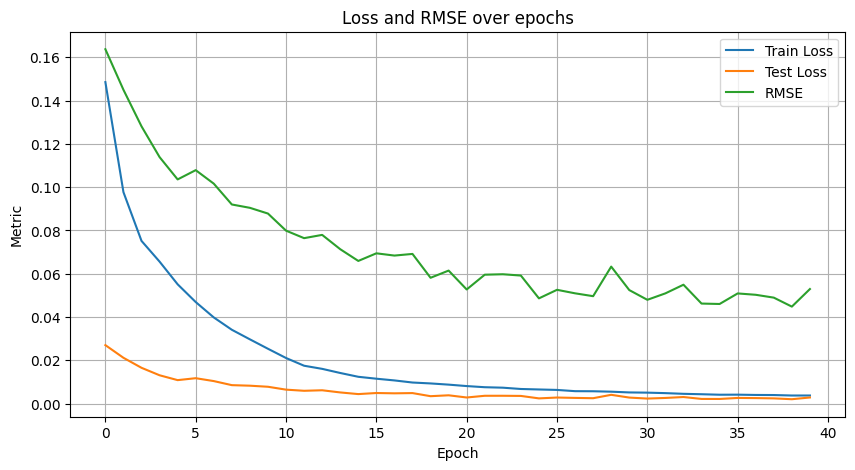

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.1160, Test Loss: 0.0195, RMSE: 0.1397
Epoch 2/40, Train Loss: 0.0767, Test Loss: 0.0159, RMSE: 0.1259
Epoch 3/40, Train Loss: 0.0582, Test Loss: 0.0124, RMSE: 0.1113
Epoch 4/40, Train Loss: 0.0464, Test Loss: 0.0111, RMSE: 0.1052
Epoch 5/40, Train Loss: 0.0374, Test Loss: 0.0090, RMSE: 0.0949
Epoch 6/40, Train Loss: 0.0297, Test Loss: 0.0096, RMSE: 0.0982
Epoch 7/40, Train Loss: 0.0240, Test Loss: 0.0068, RMSE: 0.0828
Epoch 8/40, Train Loss: 0.0196, Test Loss: 0.0054, RMSE: 0.0733
Epoch 9/40, Train Loss: 0.0163, Test Loss: 0.0057, RMSE: 0.0759
Epoch 10/40, Train Loss: 0.0143, Test Loss: 0.0046, RMSE: 0.0679
Epoch 11/40, Train Loss: 0.0123, Test Loss: 0.0049, RMSE: 0.0700
Epoch 12/40, Train Loss: 0.0108, Test Loss: 0.0036, RMSE: 0.0599
Epoch 13/40, Train Loss: 0.0100, Test Loss: 0.0031, RMSE: 0.0559
Epoch 14/40, Train Loss: 0.0089, Test Loss: 0.0038, RMSE: 0.0619
Epoch 15/40, Train Loss: 0.0079, Test Loss: 0.0029, RMSE: 0.0540
Epoch 16/40, Train Loss: 0.0075, T

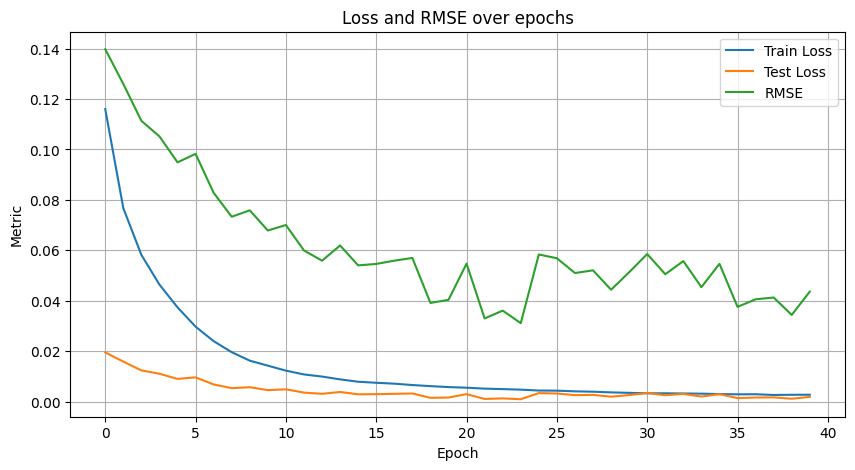

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.1174, Test Loss: 0.0178, RMSE: 0.1340
Epoch 2/40, Train Loss: 0.0741, Test Loss: 0.0138, RMSE: 0.1180
Epoch 3/40, Train Loss: 0.0553, Test Loss: 0.0113, RMSE: 0.1070
Epoch 4/40, Train Loss: 0.0428, Test Loss: 0.0089, RMSE: 0.0940
Epoch 5/40, Train Loss: 0.0350, Test Loss: 0.0084, RMSE: 0.0919
Epoch 6/40, Train Loss: 0.0274, Test Loss: 0.0065, RMSE: 0.0807
Epoch 7/40, Train Loss: 0.0221, Test Loss: 0.0063, RMSE: 0.0796
Epoch 8/40, Train Loss: 0.0183, Test Loss: 0.0045, RMSE: 0.0670
Epoch 9/40, Train Loss: 0.0150, Test Loss: 0.0043, RMSE: 0.0661
Epoch 10/40, Train Loss: 0.0130, Test Loss: 0.0043, RMSE: 0.0658
Epoch 11/40, Train Loss: 0.0113, Test Loss: 0.0019, RMSE: 0.0427
Epoch 12/40, Train Loss: 0.0103, Test Loss: 0.0027, RMSE: 0.0527
Epoch 13/40, Train Loss: 0.0092, Test Loss: 0.0028, RMSE: 0.0533
Epoch 14/40, Train Loss: 0.0084, Test Loss: 0.0022, RMSE: 0.0470
Epoch 15/40, Train Loss: 0.0076, Test Loss: 0.0029, RMSE: 0.0538
Epoch 16/40, Train Loss: 0.0071, T

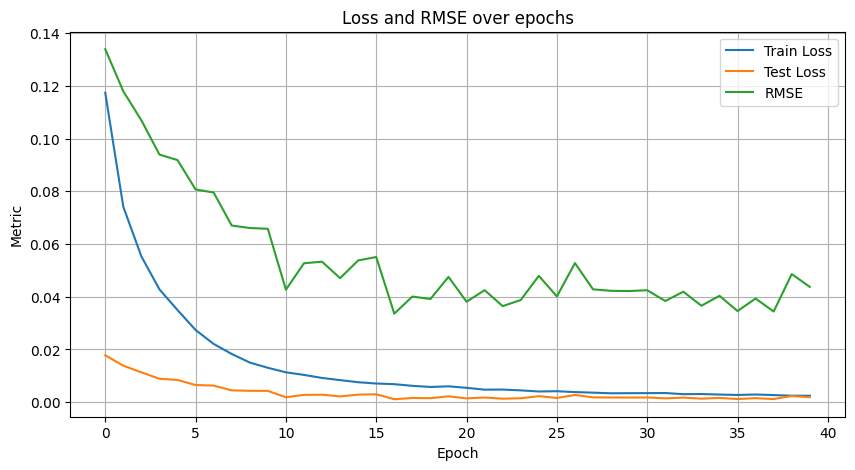

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



In [50]:
# Create cycle for training network with different amounts of data
for batch in range(3000, len(prep_bike_df), 3000):
    # Getting part of the dataset
    df_batch = prep_bike_df.head(batch)

    # Training model and getting it's weights
    model_weights, fig, model, test_data = batch_fit(df_batch, 40)

    model = model.to(torch.device('cpu'))
    data = torch.stack([test_data[i][0] for i in range(100)])
    barcodes = eXNN.topology.get_nn_barcodes(model, data, layers = ['layer1'], hom_type = "standard", coefs_type = "2")
    barcode = barcodes['layer1']

    eXNN.topology.plot_barcode(barcode)
    eXNN.topology.evaluate_barcode(barcode)

    # Saving weights, losses and topology
    os.makedirs(f'./bike_output/weights_graphs_mlp_dataamout{batch}', exist_ok=True)
    torch.save(model_weights, f'./bike_output/weights_graphs_mlp_dataamout{batch}/weights_mlp_dataamout{batch}.pth')
    fig.savefig(f'./bike_output/weights_graphs_mlp_dataamout{batch}/loss_and_rmse_mlp_dataamount{batch}.png', dpi=300, bbox_inches='tight')
    

# Getting part of the dataset
df_batch = prep_bike_df.head(len(prep_bike_df))

# Training model and getting it's weights
model_weights, fig, model, test_data = batch_fit(df_batch, 40)

model = model.to(torch.device('cpu'))
data = torch.stack([test_data[i][0] for i in range(100)])
barcodes = eXNN.topology.get_nn_barcodes(model, data, layers = ['layer1'], hom_type = "standard", coefs_type = "2")
barcode = barcodes['layer1']

eXNN.topology.plot_barcode(barcode)
eXNN.topology.evaluate_barcode(barcode)

# Saving weights and losses
os.makedirs(f'./bike_output/weights_graphs_mlp_dataamout{len(prep_bike_df)}', exist_ok=True)
torch.save(model_weights, f'./bike_output/weights_graphs_mlp_dataamout{len(prep_bike_df)}/weights_mlp_dataamout{len(prep_bike_df)}.pth')
fig.savefig(f'./bike_output/weights_graphs_mlp_dataamout{len(prep_bike_df)}/loss_and_rmse_mlp_dataamount{len(prep_bike_df)}.png', dpi=300, bbox_inches='tight')

Epoch 1/40, Train Loss: 0.1433, Test Loss: 0.0193, RMSE: 0.1402
Epoch 2/40, Train Loss: 0.0843, Test Loss: 0.0166, RMSE: 0.1297
Epoch 3/40, Train Loss: 0.0666, Test Loss: 0.0128, RMSE: 0.1138
Epoch 4/40, Train Loss: 0.0523, Test Loss: 0.0127, RMSE: 0.1134
Epoch 5/40, Train Loss: 0.0415, Test Loss: 0.0079, RMSE: 0.0896
Epoch 6/40, Train Loss: 0.0335, Test Loss: 0.0069, RMSE: 0.0836
Epoch 7/40, Train Loss: 0.0260, Test Loss: 0.0058, RMSE: 0.0771
Epoch 8/40, Train Loss: 0.0204, Test Loss: 0.0048, RMSE: 0.0700
Epoch 9/40, Train Loss: 0.0165, Test Loss: 0.0036, RMSE: 0.0607
Epoch 10/40, Train Loss: 0.0139, Test Loss: 0.0035, RMSE: 0.0595
Epoch 11/40, Train Loss: 0.0119, Test Loss: 0.0030, RMSE: 0.0551
Epoch 12/40, Train Loss: 0.0104, Test Loss: 0.0033, RMSE: 0.0581
Epoch 13/40, Train Loss: 0.0093, Test Loss: 0.0027, RMSE: 0.0526
Epoch 14/40, Train Loss: 0.0087, Test Loss: 0.0022, RMSE: 0.0472
Epoch 15/40, Train Loss: 0.0081, Test Loss: 0.0019, RMSE: 0.0442
Epoch 16/40, Train Loss: 0.0072, T

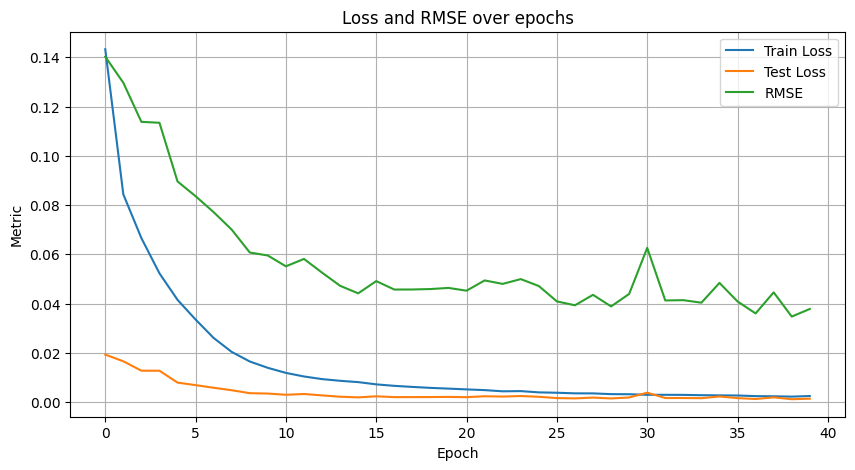

In [53]:
# Separate data into features and targets
X = prep_bike_df.iloc[:, :-1].values
y = prep_bike_df.iloc[:, -1].values
y = y.reshape(-1, 1)

# Data normalization
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=42)

# Convertation data to PyTorch tensors
train_features = torch.tensor(X_train, dtype=torch.float32)
test_features = torch.tensor(X_test, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.float32)
test_targets = torch.tensor(y_test, dtype=torch.float32)    

# Creating DataLoader
train_data = TensorDataset(train_features, train_targets)
test_data = TensorDataset(test_features, test_targets)

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

# Model initialization
model = MultiLayerPerceptron(14, 1)

# Define optimizator and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=6.4905716870829137e-05, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

# Perform training
fig = train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, scheduler, 40)


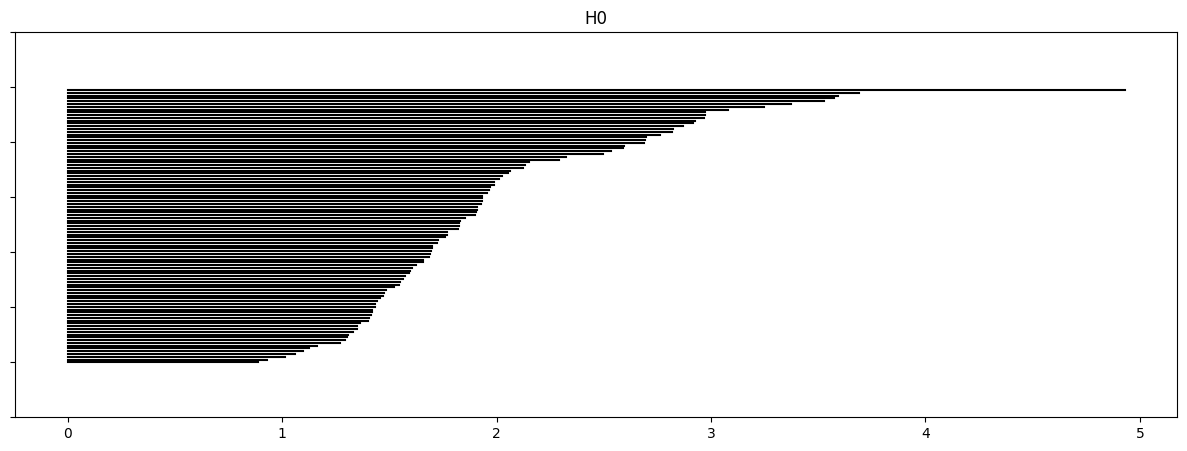

In [54]:
model = model.to(torch.device('cpu'))
data = torch.stack([test_data[i][0] for i in range(100)])
barcodes = eXNN.topology.get_nn_barcodes(model, data, layers = ['layer1'], hom_type = "standard", coefs_type = "2")
barcode = barcodes['layer1']

eXNN.topology.plot_barcode(barcode)

In [55]:
eXNN.topology.evaluate_barcode(barcode)

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



{'max_length': 4.928066253662109,
 'mean_length': 1.9862577126483725,
 'median_length': 1.8225202560424805,
 'stdev_length': 0.7131904609697092,
 'sum_length': 196.63951355218887,
 'ratio_2_1': 4.157093787372847,
 'ratio_3_1': 4.046632511091806,
 'h': 4.535924304192131,
 'normh': 0.8588533730356034,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 1.9862577126483725,
 'stdev_death': 0.7131904609697092}